## Box clustering 

In [102]:
%matplotlib notebook

In [67]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

### Reading Json


In [41]:
filename = 'dog_attrs.json.json'
file2 = 'attrs.json'

In [42]:
with open(filename,'r') as f:
    attributes = json.load(f)

In [43]:
print(len(attributes.keys()))

50


In [44]:
image_names = list(attributes.keys())

In [46]:
attributes[image_names[0]]

{'filename': 'resized_dog_1.jpg',
 'size': 11303,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 20,
    'y': 29,
    'width': 185,
    'height': 193},
   'region_attributes': {'name': 'not_defined',
    'type': 'unknown',
    'image_quality': {'good': True,
     'frontal': True,
     'good_illumination': True},
    'class': 'dog'}}],
 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}

### Description of the JSON fields

'filename': name of the image file

'size': total size of the image

'regions': details list of attributes of the image. Every element of this list is further a dictionary. In our case, there are two such elements--

1. 'shape_attributes': dictionary containing information about the shape drawn on the image. This contains keys like name(type of shape), x and y coordinates of the centre of box, width and height of the rectangles.

2. 'region_attributes': dictionary containing keys like name describing , type, image_quality(whether its good, if the mage was frontal or if it has good illumination). It also contains information about the class of the image annotated by us like dog or cat. 


 'file_attributes' : basic information about the file status like caption, whether it was in public domain and the url of the image.
 

In [55]:
all_ws=[]
all_hs=[]
for name,img in attributes.items():
    w,h = img['regions'][0]['shape_attributes']['width'],img['regions'][0]['shape_attributes']['height']
    all_ws.append(w)
    all_hs.append(h)

In [57]:
df = pd.DataFrame({'width':all_ws,'height':all_hs})

In [60]:
IMAGE_SIZE=224

In [61]:
# normalizing widths and heights

In [62]:
df = df/224

In [63]:
df.head()

,width,height
0,0.825893,0.861607
1,0.638393,0.937500
2,0.834821,0.924107
3,0.566964,0.647321
4,0.691964,0.870536


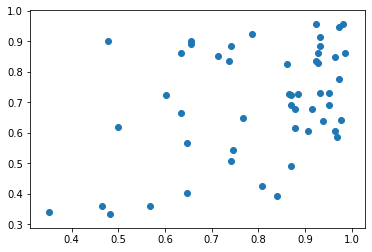

In [65]:
plt.scatter(df['height'],df['width'])
plt.show()

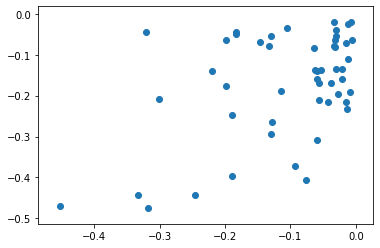

In [68]:
plt.scatter(np.log10(df['height']),np.log10(df['width']))
plt.show()

In [89]:
def calculate_iou(w1,h1,w2,h2):
    """
    Function calculates the IOU between two boxes assuming that they share there centroid    
    """
    area_intersection = min(w1,w2)*min(h1,h2)
    iou = area_intersection/(w1*h1+w2*h2-area_intersection)
    return iou

In [90]:
calculate_iou(0.9,0.6,0.5,0.5)

0.4629629629629629

### Clustering 

In [98]:
n_clusters = 20
average_ious=[]
for c in range(1,n_clusters+1):
    # define the clustering algo
    clust = KMeans(n_clusters=c)
    # fit on dataset
    clust.fit(df)
    # predict clusters for every row in data
    clust_preds = clust.predict(df)
    # extract all centroids
    centroids = clust.cluster_centers_
    # get the appropriate centroid for each data row
    predicted_centroids = centroids[clust_preds]
    #append the centroids of every data point to the row
    rows = df.values
    rows = np.c_[rows,predicted_centroids]
    # define an empty array to store the iou of every data row w.r.t its predicted centroid
    ious = []
    for r in rows:
        ious.append(calculate_iou(*list(r)))
    average_ious.append(np.mean(ious))
    
    
    
    

<IPython.core.display.Javascript object>


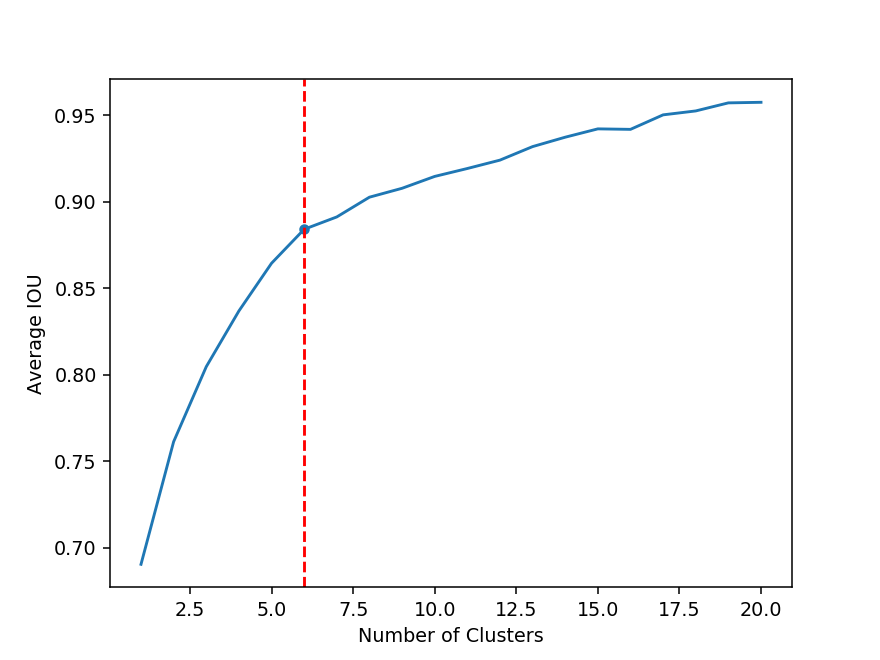

In [116]:
plt.plot(list(range(1,n_clusters+1)),average_ious)
plt.xlabel('Number of Clusters')
plt.axvline(6,linestyle='--',c='r')
plt.scatter(6,average_ious[5],s=20)
plt.ylabel('Average IOU')
plt.show()

From the above figure, it is clear that beyond 6 clusters, we sort of get dimishing returns in average IOU vs number of clusters. 
So, as per our dataset, 6 clusters seems to be the right choice